# Load Data

In [2]:

import sys

sys.path.append("../src")
from process_SHAC import load_process_SHAC

In [3]:
df_shac = load_process_SHAC(replaceNA="all")
df_shac["label_binary"] = df_shac.apply(lambda x: 1 if x["Drug"] else 0, axis=1)

df_shac["dfSource"] = df_shac["location"]
df_shac_uw = df_shac.query("location == 'uw'").reset_index(drop=True)
df_shac_mimic = df_shac.query("location == 'mimic'").reset_index(drop=True)

y_Categories = [0, 1]
n_yCats = len(y_Categories)


In [4]:
z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label = "label_binary"
n_zCats = len(z_Categories)
txt_col = "text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic

In [5]:
z_Categories.index('uw')

0

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df0["labels"] = le.fit_transform(df0[label])
df1["labels"] = le.fit_transform(df1[label])


# Load Model

In [7]:

model_path = "../output/DistilBERT_SHACBalanceAlpha_10Pct_Fix_RandomPermute_SaveModel/alpha_train__0.3333333333333333__alpha_test__0.19784466890013497__C_y__0.36000000000000004__iRun__0.pth"

# model_path = "../output/DistilBERT_SHACBalanceAlpha_RandomPermute_ShorterVersion_1_5_SaveModel/alpha_train__0.3333333333333333__alpha_test__0.19784466890013497__C_y__0.36000000000000004__iRun__0.pth/"



In [8]:
model_path

'../output/DistilBERT_SHACBalanceAlpha_10Pct_Fix_RandomPermute_SaveModel/alpha_train__0.3333333333333333__alpha_test__0.19784466890013497__C_y__0.36000000000000004__iRun__0.pth'

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import DistilBertPreTrainedModel, PretrainedConfig, DistilBertModel
from transformers import DistilBertConfig
from transformers.models.distilbert.modeling_distilbert import SequenceClassifierOutput
from transformers import DistilBertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel


import pickle
import argparse
import pandas as pd
import numpy as np
import pathlib
import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm
from copy import deepcopy

from typing import Optional
from torch.nn import MSELoss, CrossEntropyLoss
from typing import Union
from typing import Tuple
from scipy.special import softmax


def permutePercent(in_list, fixed_pct=0.1, fixed_pos=None, seed=123):
    # fixed_pos: list of fixed positions
    N = len(in_list)

    if (fixed_pos is None) and fixed_pct:
        fixed_n = int(np.ceil(N * fixed_pct))
        random.seed(seed)
        fixed_pos = random.sample(range(0, N), fixed_n)

    elif (fixed_pos is None) and (fixed_pct is None):
        os.error("No Fixed Position Provided")

    ret_ls = [idx if idx in fixed_pos else x for idx, x in enumerate(in_list)]

    set_diff = set(in_list) - set(ret_ls)
    set_dups = [i for i in set(ret_ls) if ret_ls.count(i) > 1]

    while len(set_dups):
        a = set_dups.pop()
        r = set_diff.pop()
        for idx, x in enumerate(ret_ls):
            if (x == a) and (idx not in fixed_pos):
                ret_ls[idx] = r
                break
    return ret_ls

# class PermDistilBertForSequenceClassification(DistilBertPreTrainedModel):
#     def __init__(self, config: PretrainedConfig):
#         super().__init__(config)
#         self.num_labels = config.num_labels
#         self.num_sources = 2
#         self.config = config

#         self.distilbert = DistilBertModel(config)
#         self.pre_classifier = nn.Linear(config.dim, config.dim)
#         # pemb[2] (in general, pemb[last]) is the identity permutation
#         self.pemb = torch.stack(
#             [torch.randperm(config.dim) for i in range(2)] + [torch.arange(0, config.dim)]
#         )
#         self.pemb = torch.nn.Parameter(self.pemb, requires_grad=False)
#         self.classifier = nn.Linear(config.dim, config.num_labels)
#         self.dropout = nn.Dropout(config.seq_classif_dropout)

#         # Initialize weights and apply final processing
#         self.post_init()

#     def get_position_embeddings(self) -> nn.Embedding:
#         """
#         Returns the position embeddings
#         """
#         return self.distilbert.get_position_embeddings()

#     def resize_position_embeddings(self, new_num_position_embeddings: int):
#         """
#         Resizes position embeddings of the model if `new_num_position_embeddings != config.max_position_embeddings`.

#         Arguments:
#             new_num_position_embeddings (`int`):
#                 The number of new position embedding matrix. If position embeddings are learned, increasing the size
#                 will add newly initialized vectors at the end, whereas reducing the size will remove vectors from the
#                 end. If position embeddings are not learned (*e.g.* sinusoidal position embeddings), increasing the
#                 size will add correct vectors at the end following the position encoding algorithm, whereas reducing
#                 the size will remove vectors from the end.
#         """
#         self.distilbert.resize_position_embeddings(new_num_position_embeddings)

#     # @add_start_docstrings_to_model_forward(DISTILBERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
#     # @add_code_sample_docstrings(
#     #     checkpoint=_CHECKPOINT_FOR_DOC,
#     #     output_type=SequenceClassifierOutput,
#     #     config_class=_CONFIG_FOR_DOC,
#     # )
#     def forward(
#         self,
#         input_ids: Optional[torch.Tensor] = None,
#         attention_mask: Optional[torch.Tensor] = None,
#         head_mask: Optional[torch.Tensor] = None,
#         inputs_embeds: Optional[torch.Tensor] = None,
#         labels: Optional[torch.LongTensor] = None,
#         output_attentions: Optional[bool] = None,
#         output_hidden_states: Optional[bool] = None,
#         return_dict: Optional[bool] = None,
#         source: Optional[int] = None,
#     ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
#         r"""
#         labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
#             Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
#             config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
#             `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
#         """
#         return_dict = (
#             return_dict if return_dict is not None else self.config.use_return_dict
#         )

#         distilbert_output = self.distilbert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             head_mask=head_mask,
#             inputs_embeds=inputs_embeds,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#         )
#         hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
#         pooled_output = hidden_state[:, 0]  # (bs, dim)
#         pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
#         pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
#         pooled_output = self.dropout(pooled_output)  # (bs, dim)

#         if source is None:
#             # Use the last
#             perm_ids = self.num_sources * np.ones(pooled_output.shape[0])
#         else:
#             perm_ids = np.asarray(
#                 [source.cpu().numpy()]
#             )  # for i in range(pooled_output.shape[0])])

#         perms = self.pemb[perm_ids]
#         sub_permuted = torch.gather(pooled_output, -1, perms)

#         logits = self.classifier(sub_permuted)  # (bs, num_labels)

#         loss = None
#         if labels is not None:
#             if self.config.problem_type is None:
#                 if self.num_labels == 1:
#                     self.config.problem_type = "regression"
#                 elif self.num_labels > 1 and (
#                     labels.dtype == torch.long or labels.dtype == torch.int
#                 ):
#                     self.config.problem_type = "single_label_classification"
#                 else:
#                     self.config.problem_type = "multi_label_classification"

#             if self.config.problem_type == "regression":
#                 loss_fct = MSELoss()
#                 if self.num_labels == 1:
#                     loss = loss_fct(logits.squeeze(), labels.squeeze())
#                 else:
#                     loss = loss_fct(logits, labels)
#             elif self.config.problem_type == "single_label_classification":
#                 loss_fct = CrossEntropyLoss()
#                 loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#             elif self.config.problem_type == "multi_label_classification":
#                 # NOTE: to verify here
#                 loss_fct = CrossEntropyLoss()
#                 loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

#         if not return_dict:
#             output = (logits,) + distilbert_output[1:]
#             return ((loss,) + output) if loss is not None else output

#         return SequenceClassifierOutput(
#             loss=loss,
#             logits=logits,
#             hidden_states=distilbert_output.hidden_states,
#             attentions=distilbert_output.attentions,
#         ), sub_permuted, hidden_state[:, 0], pooled_output
    
    
class PermDistilBertForSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config: PretrainedConfig):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.num_sources = 2
        self.config = config
        self.fixed_pct = config.fixed_pct
        self.permseed = config.permseed
        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)

        # pemb[2] (in general, pemb[last]) is the identity permutation

        ret_ls = []
        for i in range(self.num_sources):
            while True:
                tmp_ts = torch.randperm(config.dim)
                tmp_ls = permutePercent(
                    in_list=tmp_ts.tolist(),
                    fixed_pct=self.fixed_pct,
                    seed=self.permseed,
                )
                if (tmp_ls not in ret_ls) and (
                    tmp_ls not in ([np.arange(self.num_sources).tolist()])
                ):
                    ret_ls.append(tmp_ls)
                    break
        self.pemb = torch.cat(
            (torch.tensor(ret_ls), torch.arange(0, config.dim).unsqueeze(0))
        )

        self.pemb = torch.nn.Parameter(self.pemb, requires_grad=False)

        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        # Initialize weights and apply final processing
        self.post_init()

    def get_position_embeddings(self) -> nn.Embedding:
        """
        Returns the position embeddings
        """
        return self.distilbert.get_position_embeddings()

    def resize_position_embeddings(self, new_num_position_embeddings: int):
        """
        Resizes position embeddings of the model if `new_num_position_embeddings != config.max_position_embeddings`.

        Arguments:
            new_num_position_embeddings (`int`):
                The number of new position embedding matrix. If position embeddings are learned, increasing the size
                will add newly initialized vectors at the end, whereas reducing the size will remove vectors from the
                end. If position embeddings are not learned (*e.g.* sinusoidal position embeddings), increasing the
                size will add correct vectors at the end following the position encoding algorithm, whereas reducing
                the size will remove vectors from the end.
        """
        self.distilbert.resize_position_embeddings(new_num_position_embeddings)

    # @add_start_docstrings_to_model_forward(DISTILBERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    # @add_code_sample_docstrings(
    #     checkpoint=_CHECKPOINT_FOR_DOC,
    #     output_type=SequenceClassifierOutput,
    #     config_class=_CONFIG_FOR_DOC,
    # )
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        source: Optional[int] = None,
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)

        if source is None:
            # Use the last
            perm_ids = self.num_sources * np.ones(pooled_output.shape[0])
        else:
            perm_ids = np.asarray(
                [source.cpu().numpy()]
            )  # for i in range(pooled_output.shape[0])])

        perms = self.pemb[perm_ids]
        sub_permuted = torch.gather(pooled_output, -1, perms)

        logits = self.classifier(sub_permuted)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (
                    labels.dtype == torch.long or labels.dtype == torch.int
                ):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                # NOTE: to verify here
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        ), sub_permuted, hidden_state[:, 0], pooled_output

class train_config:
    def __init__(self):
        self.quantization: bool = False



In [10]:

globalconfig = train_config()

globalconfig.tokenizer_max_len = 512


In [11]:
model = PermDistilBertForSequenceClassification.from_pretrained(model_path)

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.max_len = globalconfig.tokenizer_max_len

# Toeknize

In [13]:
for _ in [df0, df1]:
    _["tokenized"] = _[txt_col].apply(
        lambda x: tokenizer(
            x,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=globalconfig.tokenizer_max_len,
        )
    )
    for i, row in _.iterrows():
        row["tokenized"].update(
            {"labels": torch.tensor(int(row["labels"]), dtype=torch.long)}
        )
        row["tokenized"].update(
            {
                "source": torch.tensor(
                    int(z_Categories.index(row[domain_col])), dtype=torch.long
                )
            }
        )  # NOTE: this only works for binary Category cases!!!
        row["tokenized"].update({"input_ids": row["tokenized"]["input_ids"].squeeze()})
        row["tokenized"].update(
            {"attention_mask": row["tokenized"]["attention_mask"].squeeze()}
        )

In [14]:
for _df in [df0, df1]:
    for i in range(n_zCats + 1):
        _df[f"tokenized_sr{i}"] = _df.apply(
            lambda x: deepcopy(x["tokenized"]), axis=1
        )
        for _, row in _df.iterrows():
            row[f"tokenized_sr{i}"]["source"] = torch.tensor(i, dtype=torch.long)


# Output

In [15]:
def getOutput(tokenized):
    
    model.eval()
    with torch.no_grad():
        example_i = tokenized

        output = model(input_ids=example_i['input_ids'], attention_mask=example_i['attention_mask'], labels=example_i['labels'], source=example_i['source'],
                       output_attentions=True,
                       output_hidden_states=True,
                       return_dict=True,

                      )
    return output

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
x_df0_sr0, x_df0_sr1, x_df0_sr2 = [],[],[]
x_df1_sr0, x_df1_sr1, x_df1_sr2 = [],[],[]


for index, row in df0.iterrows():
    x_df0_sr0.append(getOutput(row['tokenized_sr0'])[1:])
    x_df0_sr1.append(getOutput(row['tokenized_sr1'])[1:])
    x_df0_sr2.append(getOutput(row['tokenized_sr2'])[1:])

for index, row in df1.iterrows():
    x_df1_sr0.append(getOutput(row['tokenized_sr0'])[1:])
    x_df1_sr1.append(getOutput(row['tokenized_sr1'])[1:])
    x_df1_sr2.append(getOutput(row['tokenized_sr2'])[1:])


In [33]:
x_df0_sr0 = np.array(x_df0_sr0)
x_df0_sr1 = np.array(x_df0_sr1)
x_df0_sr2 = np.array(x_df0_sr2)

x_df1_sr0 = np.array(x_df1_sr0)
x_df1_sr1 = np.array(x_df1_sr1)
x_df1_sr2 = np.array(x_df1_sr2)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

0.33321065
0.48082128
0.33580345
0.471619


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc1d98363a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc1d98367c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc1d9836100>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc1d9836d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc1d9836fa0>,
 'means': []}

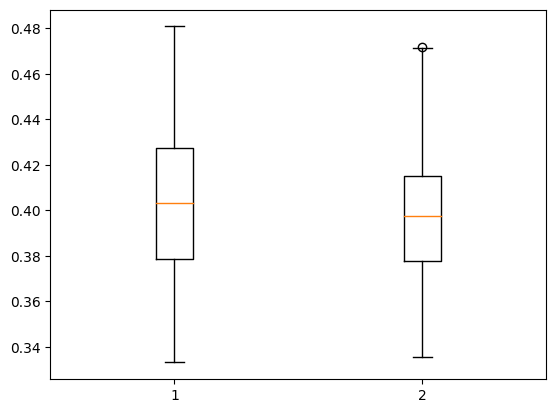

In [35]:
sims_df0 = [cosine_similarity(x[0],y[0])[0][0] for x,y in zip(x_df0_sr0, x_df0_sr1)]
sims_df1 = [cosine_similarity(x[0],y[0])[0][0] for x,y in zip(x_df1_sr0, x_df1_sr1)]

print(min(sims_df0))
print(max(sims_df0))
print(min(sims_df1))
print(max(sims_df1))

plt.boxplot(x=(sims_df0, sims_df1))

0.33321065
0.48082128
0.33580345
0.471619


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc1cf2c7fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc1cf2d1550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc1cf2c7e50>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc1cf2d1a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc1cf2d1d30>,
 'means': []}

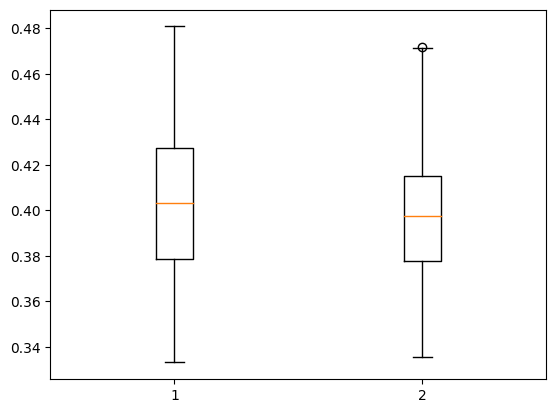

In [36]:
sims_df0 = [cosine_similarity(x[0],y[0])[0][0] for x,y in zip(x_df0_sr0, x_df0_sr1)]
sims_df1 = [cosine_similarity(x[0],y[0])[0][0] for x,y in zip(x_df1_sr0, x_df1_sr1)]

print(min(sims_df0))
print(max(sims_df0))
print(min(sims_df1))
print(max(sims_df1))

plt.boxplot(x=(sims_df0, sims_df1))

In [37]:
sims_df0 = [cosine_similarity(x[1],y[1])[0][0] for x,y in zip(x_df0_sr0, x_df0_sr1)]
sims_df1 = [cosine_similarity(x[1],y[1])[0][0] for x,y in zip(x_df1_sr0, x_df1_sr1)]


print(min(sims_df0))
print(max(sims_df0))
print(min(sims_df1))
print(max(sims_df1))

0.9999996
1.0000005
0.9999996
1.0000005


In [38]:
sims_df0 = [cosine_similarity(x[2],y[2])[0][0] for x,y in zip(x_df0_sr0, x_df0_sr1)]
sims_df1 = [cosine_similarity(x[2],y[2])[0][0] for x,y in zip(x_df1_sr0, x_df1_sr1)]


print(min(sims_df0))
print(max(sims_df0))
print(min(sims_df1))
print(max(sims_df1))

0.99999964
1.0000002
0.99999976
1.0000002


In [39]:
x_df0_sr0.shape

(2528, 3, 1, 768)

In [40]:
tmp = cosine_similarity(x_df0_sr0[:, 2, 0, :], x_df1_sr1[:, 2, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,4.745056e+06
mean,6.643224e-01
std,3.525064e-01
min,8.392964e-03
25%,2.956829e-01
50%,8.569562e-01
75%,9.806013e-01
max,1.000000e+00


In [41]:
tmp = cosine_similarity(x_df0_sr0[:, 0, 0, :], x_df1_sr1[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,4.745056e+06
mean,2.909885e-01
std,1.185814e-01
min,9.638192e-02
25%,1.658968e-01
50%,3.443460e-01
75%,3.967049e-01
max,4.758790e-01


In [42]:
tmp = cosine_similarity(x_df0_sr1[:, 0, 0, :], x_df1_sr0[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,4.745056e+06
mean,3.052970e-01
std,1.044592e-01
min,9.732349e-02
25%,2.017653e-01
50%,3.466748e-01
75%,3.950309e-01
max,4.868950e-01


In [43]:
tmp = cosine_similarity(x_df1_sr0[:, 0, 0, :], x_df1_sr1[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,3.523129e+06
mean,3.236930e-01
std,1.021970e-01
min,9.697229e-02
25%,2.469525e-01
50%,3.739005e-01
75%,3.989044e-01
max,4.778463e-01


In [44]:
tmp = cosine_similarity(x_df0_sr0[:, 0, 0, :], x_df0_sr1[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,6.390784e+06
mean,2.911818e-01
std,1.150198e-01
min,9.652640e-02
25%,1.749979e-01
50%,3.262246e-01
75%,3.959108e-01
max,4.858800e-01


In [45]:
tmp = cosine_similarity(x_df1_sr0[:, 0, 0, :], x_df1_sr1[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,3.523129e+06
mean,3.236930e-01
std,1.021970e-01
min,9.697229e-02
25%,2.469525e-01
50%,3.739005e-01
75%,3.989044e-01
max,4.778463e-01


In [47]:
tmp = cosine_similarity(x_df0_sr2[:, 0, 0, :], x_df0_sr0[:, 0, 0, :]).reshape(1,-1)

pd.DataFrame(tmp).T.describe()

,0
count,6.390784e+06
mean,2.750075e-01
std,4.903536e-02
min,1.705512e-01
25%,2.315050e-01
50%,2.885957e-01
75%,3.121051e-01
max,3.732311e-01


In [55]:
tmp = np.diagonal(cosine_similarity(x_df0_sr2[:, 0, 0, :], x_df0_sr0[:, 0, 0, :]))

pd.DataFrame(tmp).describe()

,0
count,2528.000000
mean,0.324756
std,0.020818
min,0.287511
25%,0.303180
50%,0.327467
75%,0.343444
max,0.373231
